# Nonparametric Bayesian label prediction on a graph

This notebook contains the plots and parts of the storyline for the presentation of the doctoral thesis "Nonparametric Bayesian label prediction on a graph" that is comprehensible to non-specialists. It includes an analysis of simulated station traffic data on the Transport for London network (tube, DLR, cable car, overground, TfL rail and tram connections). The edges in the network are actual connections and stations that are within walking distance as per the [TfL network](http://content.tfl.gov.uk/large-print-tube-map.pdf) (May 2019).

* The data folder contains the edge list of the TfL network and station coordinates and zones in .csv format. The Lines.xlsx file contains the edge list with a separate sheet per transport line, it is not used in our script, but included for readability.
* The modules folder contains thesis_presentation_aux.py which is a module with auxiliary functions used in this notebook.
* This notebook contains the storyline, plots and example analysis of the TfL network.

In [1]:
## module

import csv
from matplotlib.colors import LinearSegmentedColormap
import networkx as nx
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

def eigen_basis(network, k):
    """Computes the k smallest eigenvalues and corresponding eigenvectors of
    the Laplacian matrix of the network."""
    L = nx.laplacian_matrix(network)
    lmbda, U = eigsh(L.asfptype(), which='SM', k=k)
    return lmbda, U


def estimate_labels(lmbda, U, obs, c, k):
    """Estimates the underlying function on a network using the observations."""
    n = len(obs)
    miss = np.isnan(obs)
    lmbda[0] = lmbda[1]  # to make eigenvalues invertible
    Lmbda = diags(1.0 / lmbda[0:k])
    U_obs = U[~miss, 0:k]
    estimate = U[:,0:k].dot(np.linalg.solve(U_obs.T.dot(U_obs)
                            + c * Lmbda, U_obs.T.dot(obs[~miss])))
    return estimate


def rag_colormap():
    """Defines a red-amber-green colormap."""
    rag = LinearSegmentedColormap.from_list('RAG',
        ['xkcd:green', 'xkcd:amber', 'xkcd:red'])
    return rag


def read_station_data(file, **kwargs):
    """Reads stations coordinates and zone from a file."""
    coordinates = {}
    zones = {}
    with open(file) as stations_file:
        station_reader = csv.reader(stations_file, **kwargs)
        for row in station_reader:
            coordinates[row[0]] = [float(row[1]), float(row[2])]
            zones[row[0]] = row[3]
    return coordinates, zones


def rough_example(n):
    """Returns n function values of a rough function."""
    return np.random.normal(size=n)

def smooth_example(n):
    """Returns n function values of a smooth function."""
    return np.random.normal(size=n)

def plot_network(network, position, value, colormap=None, **kwargs):
    """Plots a network using fixed node size and edge color."""
    nx.draw(network, pos=position,
            node_size=75, node_color=value,
            cmap=colormap,
            edge_color='xkcd:light grey',
            **kwargs)
    
def plot_path_graph(ax, f, color='xkcd:blue', **kwargs):
    ax.plot(f, linewidth=2, c=color, **kwargs)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


def tfl_zone_labels(tfl, zones, p):
    """Use zone data to make labels on the TfL network. An approximate fraction
    p of the labels will be missing."""

    def tfl_zone_value(zone):
        """Assigns a value to each zone."""
        try:
            return 10.0 - float(zone)
        except ValueError:
            if zone == "S":
                return 6.5
            else:
                zone_list = list(map(float, zone.split("/")))
                return 10 - sum(zone_list) / len(zone_list)

    zone_label = []
    for station in tfl.nodes:
        missing = np.random.random() < p
        if missing:
            zone_label.append(None)
        else:
            zone_label.append(tfl_zone_value(zones[station]) + np.random.normal())
    return np.array(zone_label, dtype=float)

In [2]:
# from modules.thesis_presentation_aux import *
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

## Introduction

My research is about label prediction on a graph. A graph, or network, I encounter or hear about almost every day is the tube in London. This presentation will introduce some of the concepts related to my thesis to give you some idea of its contents.

Let's have a look at the TfL (Transport for London) network. It consists of tube, DLR, cable car, overground, TfL rail and trams connections.

![TfL map](data/tube-map.gif)

We can also represent the TfL network using a node for each station and connecting the nodes if there is a line, internal interchange or under 10 minutes walk between them. We use the (geographic) coordinates of each station to make a similar picture as the above map. This will be the represenation of the TfL network we work with.

C:\Users\xl273xm\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


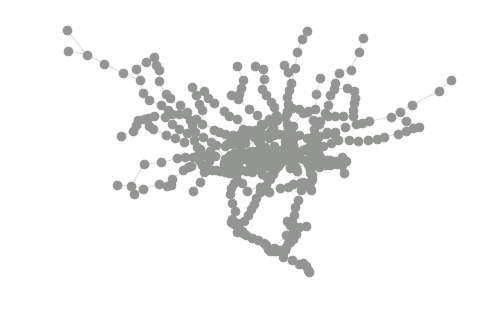

In [3]:
tfl = nx.read_edgelist('data/lines', delimiter='|')
coordinates, zones = read_station_data('data/stations.csv', delimiter='|')
plot_network(tfl, coordinates, 'xkcd:grey')

One of the features of the TfL network is that it can be very busy in peak hours. We represent how crowded a station is on a red-amber-green color scale with red being overcrowded and green being quiet. Let's say we have collected information about the stations in the network. Some stations are busy (red) and other stations are quiet (green). For half of the stations we have no information (light grey). Additionally, the information we have might have measurement errors. 

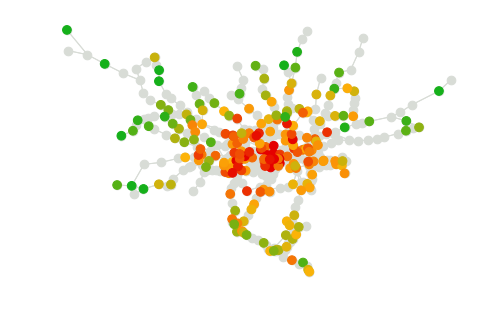

In [4]:
tfl_labels = tfl_zone_labels(tfl, zones, 0.5)
plot_network(tfl, coordinates, 'xkcd:light grey')
plot_network(tfl, coordinates, tfl_labels, colormap=rag_colormap(), vmin=4, vmax=10)

In my research, I have developed methods to complete this picture and get rid of the noise. We will use the incomplete and noisy observation of station crowdedness to predict the crowdedness of the entire network. The underlying assumption of these methods is that stations that are close to each other in the network should be about equally busy.

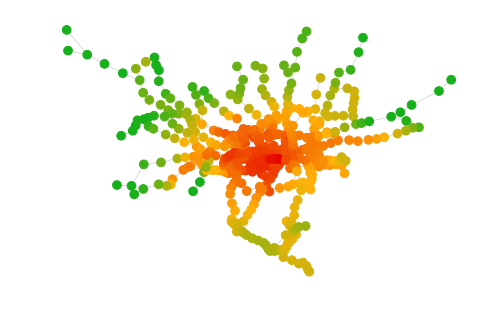

In [5]:
tfl_eigenvalues, tfl_basis = eigen_basis(tfl, 200)
tfl_estimate = estimate_labels(tfl_eigenvalues, tfl_basis, tfl_labels, 1e-6, 50)
plot_network(tfl, coordinates, tfl_estimate, colormap=rag_colormap(), vmin=4, vmax=10)

## Smoothness and roughness

The assumption that stations that are close to each other, for example consecutive stations on a line, should be about equaly busy is a form of smoothness of the crowdedness function on the graph. If we forget about the TfL network for now and focus and think of the crowdedness function as a function on a single line, we can use pictures to understand the concept of smoothness. The smoothness is how much the function varies from one node to the next. If this variation is small, the function is smooth and if the variation is high, the function is rough.

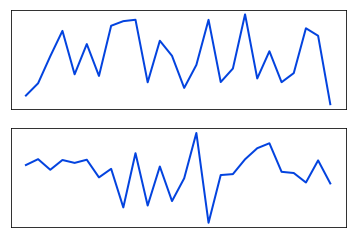

In [6]:
line = nx.path_graph(26)
line_rough = rough_example(len(line))
line_smooth = smooth_example(len(line))
fig, axs = plt.subplots(2)
plot_path_graph(axs[0], line_rough)
plot_path_graph(axs[1], line_smooth)

Apart from the network structure, we keep all other important aspects of our problem: we have an incomplete, noisy observation of station crowdedness on the line. This is actually a special case of our network problem, where the network is a single line. We can now visualize what kind of result we would like to achieve: a smooth function on the line. 

To find the correct function on the line, we should recognize that there is a balance between two extremes: 
* fitting the observations, with the extreme case of just connecting the dots;
* having a smooth function, with the extreme case of a straight line.

If we go back to the TfL network, we can see that the concept of smoothness can still make sense. A rough function would vary a lot between neighboring stations, whereas a smooth function only varies a little and we would like to find the right balance.

## Frequency and scale
To make our method as generally applicable as possible, we would like to make as little assumptions on the underlying function as possible. To this end, we will build our estimate using simple basis functions. For a function on a line, these basis function will correspond to frequencies.

We can build any function using these basis functions, as long as we include high enough frequencies to allow for more detail. In light of our previous insights in smoothness and roughness, we can see that low frequencies correspond to smooth functions (little variation between neighbors) and high frequencies correspond to rough functions (a lot of variation between neighbors). If we are to balance smoothness and roughness, we will only include basis functions up to a certain frequency.

A second tool we can use to balance smoothness and roughness is the scale of our basis functions. The frequency dictates how many times the function goes up and down, the scale dictates by how much is goes up or down. We can conclude that a low scale corresponds to smooth functions and a high scale corresponds to rough functions.

To make these concepts work for arbitrary graphs, such as the TfL network, we have to identify what the basis functions are in a network setting. The details of their construction are beyond the scope of this presentation, but for the TfL network they still display some form of frequency in terms of how many times function changes from red to green.

The generalization of scale on the TfL network is the intensity of the change between color of neighboring nodes.

To make a good estimate of the function, we have to: 
* include basis functions up to a certain frequency (truncation level); 
* scale the basis functions by a certain amount (regularization). 

In my thesis, I set these parameters in three different ways that can be rougly characterized as:
* random sampling (MCMC);
* optimization (empirical Bayes);
* approximation and optimization (variational Bayes).